In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#Importation des librairies
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#On modifie les options pour rendre l'affichage des float plus lisible
pd.set_option('float_format', '{:f}'.format)

In [4]:
#On définit les colonnes du dataset qui nous serons utiles 
fields = ['code', 'product_name','generic_name','brands','categories','origins','labels','cities','purchase_places','stores','countries','ingredients_text','allergens','additives_n','nutriscore_score','nutriscore_grade','nova_group','pnns_groups_1','pnns_groups_2','ecoscore_score_fr','ecoscore_grade_fr','main_category','image_url','energy-kj_100g',
'energy-kcal_100g','salt_100g','sodium_100g','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','carbohydrates_100g']

df = pd.read_csv("en.openfoodfacts.org.products.csv", sep='\t', usecols=fields)

Les colonnes ont été choisies en fonction de nos besoins pour l'application et suite à diverses recherches et tests statistiques sur le dataset

Dans un premier temps nous allons vérifier le nombre de produits dans le dataset puis commencer à éliminer toutes les entrées ne correspondant pas à nos besoins pour l'application. Ici nous retirerons alors les données dont le nom est absent ainsi que les données de produits non français par soucis de lisibilité et de disponibilité en magasin.

In [5]:
print("Données de base : ")
print(df['code'].describe())

Données de base : 
count         2017243
unique        2016995
top       84909900098
freq                3
Name: code, dtype: int64


In [6]:
df = df[df['product_name'].str.strip().astype(bool)]
print("Après filtre non vide : ")
print(df['code'].describe())

Après filtre non vide : 
count         2017242
unique        2016994
top       84909900098
freq                3
Name: code, dtype: int64


In [7]:
df = df[df['countries'] == 'France']
print("Après filtre France : ")
print(df['code'].describe())

Après filtre France : 
count            435377
unique           435369
top       3770008983205
freq                  2
Name: code, dtype: int64


In [8]:
df['categories'].replace('', np.nan, inplace=True)
df.dropna(subset=['categories'], inplace=True)
print(df['code'].describe())

count             263290
unique            263285
top       30383354190402
freq                   2
Name: code, dtype: object


Nous supprimons toutes les catégories vides car il nous est impossible de proposer un produit similaire au produit entré sans connaitre sa catégorie

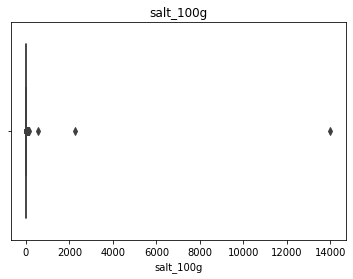

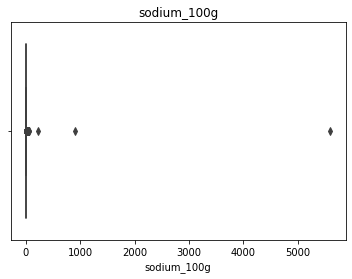

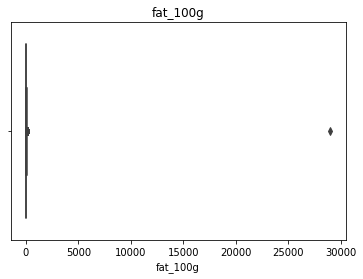

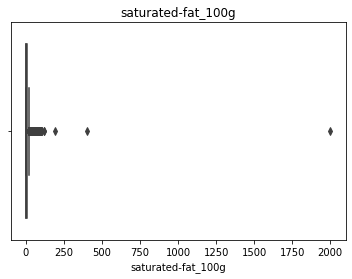

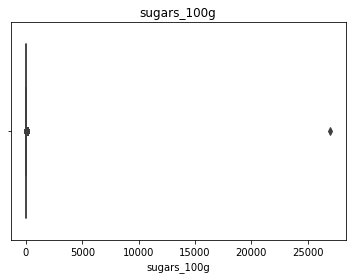

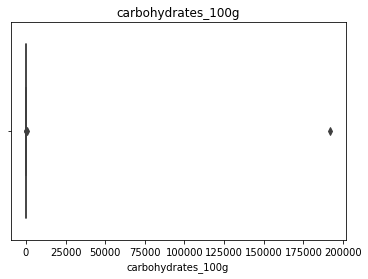

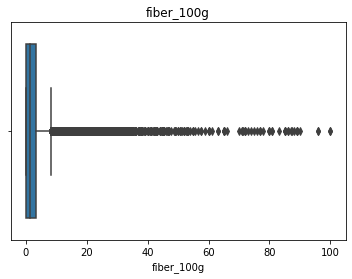

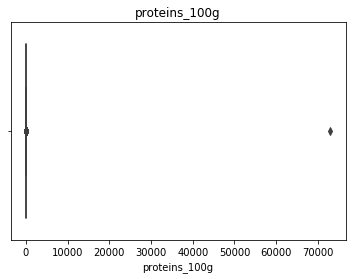

In [9]:
for var in ["salt_100g","sodium_100g","fat_100g","saturated-fat_100g","sugars_100g","carbohydrates_100g","fiber_100g","proteins_100g"]:
    sns.boxplot(x=var, data=df)
    plt.title(var)
    plt.show()

On remarque assez vite ici qu'il y a des valeurs dépassant le seuil de 100grammes. Il s'agit probablement de valeurs entrées en miligrammes au lieu de grammes mais nous allons les supprimer car cela demanderait une vérification manuelle pour chaque produit.

Nous allons donc procéder à un nettoyage de toutes les valeurs en dehors des bornes 0 à 100, sauf pour le sodium qui sera entre les bornes 0 à 40 car il ne peut pas excéder cette valeur, nous verrons pourquoi par la suite.

In [10]:
df = df[df['salt_100g']>=0]
df = df[df['salt_100g']<=100.0]

df = df[df['sodium_100g']>=0]
df = df[df['sodium_100g']<=40]

df = df[df['fat_100g']>=0]
df = df[df['fat_100g']<=100.0]

df = df[df['saturated-fat_100g']>=0]
df = df[df['saturated-fat_100g']<=100.0]

df = df[df['sugars_100g']>=0]
df = df[df['sugars_100g']<=100.0]

df = df[df['fiber_100g']>=0]
df = df[df['fiber_100g']<=100.0]

df = df[df['carbohydrates_100g']>=0]
df = df[df['carbohydrates_100g']<=100.0]

df = df[df['proteins_100g']>=0]
df = df[df['proteins_100g']<=100.0]

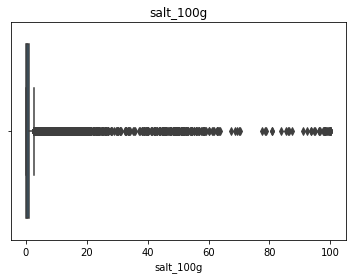

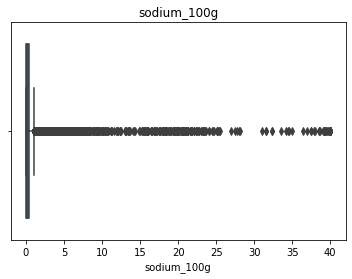

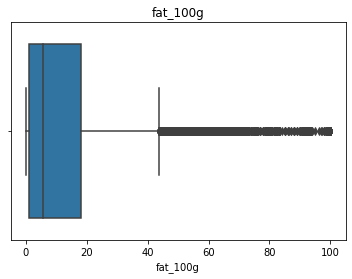

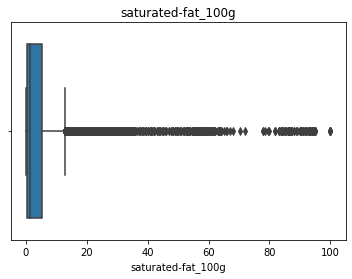

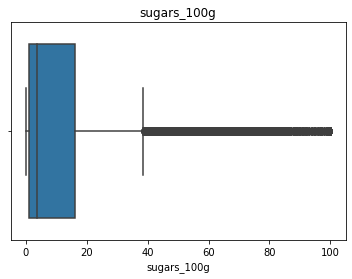

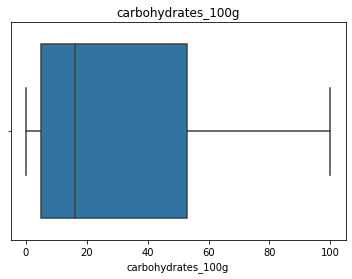

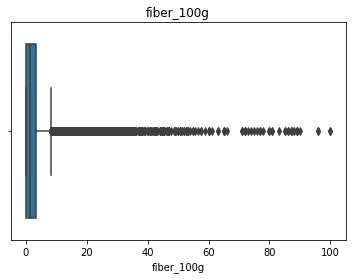

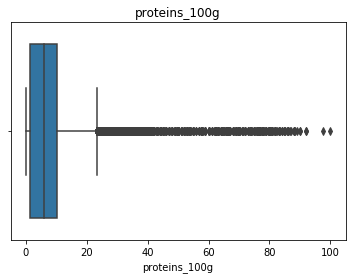

In [11]:
for var in ["salt_100g","sodium_100g","fat_100g","saturated-fat_100g","sugars_100g","carbohydrates_100g","fiber_100g","proteins_100g"]:
    sns.boxplot(x=var, data=df)
    plt.title(var)
    plt.show()

Nous avons maintenant des boxplot correspondant bien mieux à ce que l'on pouvait s'attendre. On remarque également que le boxplot de sel et celui de sodium ont l'air similaires à leur échelle. Il est donc intéressant de voir s'il y a des corrélations entre les différentes variables que nous avons.

Pour cela nous allons réaliser une heatmap relevant les corrélations entre chacune de ces variables sur une échelle de 1 à 10:

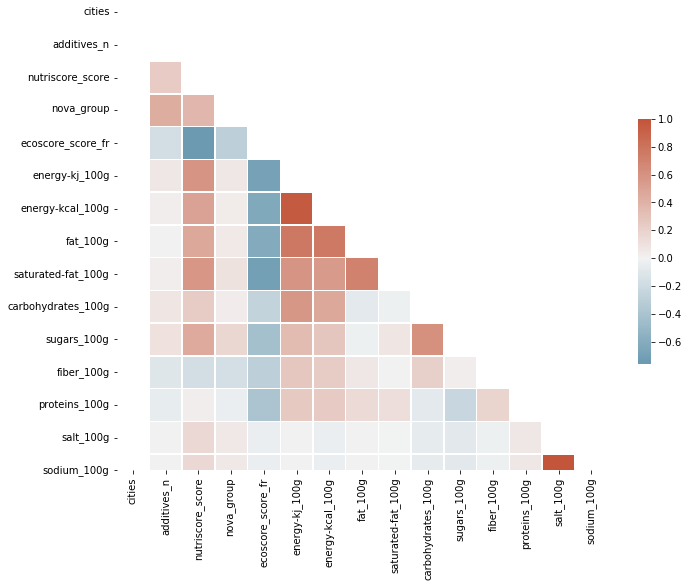

In [12]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Nous pouvons distinguer que le sel et le sodium sont très corrélés ainsi que la graisse et la graisse saturée, nous allons donc tester ces valeurs avec un scatterplot pour déterminer s'il y a une relation entre ces deux variables

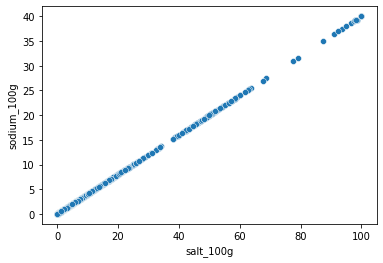

In [13]:
dfSample = df.sample(50000) # Nous prenons un échantillon de 50 000 entités pour accélérer le processus
xdataSample, ydataSample = dfSample["salt_100g"], dfSample["sodium_100g"]

sns.scatterplot(data=dfSample, x="salt_100g", y="sodium_100g") 
plt.show()

Nous pouvons effectivement voir une belle relation entre ces deux variables grâce à cette diagonale sur le graphique.

Après quelques recherches nous trouvons rapidement qu'il existe bel et bien une relation d'un coefficient de 2,54 entre ces deux variables (1gramme de sodium équivaut à 2,54 grammes de sel), ce qui nous permet de savoir qu'il n'y aura jamais plus de 40grammes de sodium dans une portion de 100grammes d'aliment

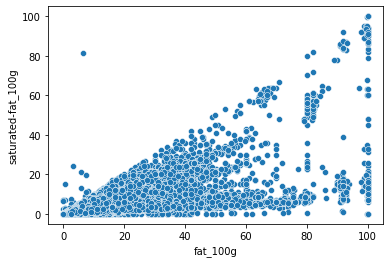

In [14]:
dfSample = df.sample(50000) # Nous prenons un échantillon de 50 000 entités pour accélérer le processus
xdataSample, ydataSample = dfSample["fat_100g"], dfSample["saturated-fat_100g"]

sns.scatterplot(data=dfSample, x="fat_100g", y="saturated-fat_100g") 
plt.show()

Pour les graisses et les graisses saturées nous pouvons également relever une corrélation mais il n'y a pas de coefficient visible entre ces deux variables. On peut néamoins remarquer qu'il parait impossible que les graisses saturées dépasse le taux de graisses, mis à part quelques cas qui sont potentiellement des erreurs.

Maintenant que nous connaissons la relation entre le sel et le sodium nous allons pouvoir procéder à une vérification pour chaque produit afin d'être sur que les données soient qualitatives

In [15]:
print("Avant vérification :",df["code"].count())
df = df.loc[abs(df['salt_100g']-df['sodium_100g']*2.54) < df['salt_100g']*0.05]
print("Après vérification :",df["code"].count())



Avant vérification : 86429
Après vérification : 74552


En ayant mis une tolérance de 5% de différence entre les valeurs données et les valeurs calculées nous avons quand même exclus une bonne partie des données qui sont potentiellement erronées

En faisant nos recherches sur la relation entre le sel et le sodium nous avons découvert que la graisse comprends les graisses saturées et que les glucides comprennent le sucre et les fibres.
Nous pouvons donc vérifier que ces valeurs ne dépassent pas le taux de graisse et le taux de glucides liés.

In [16]:
print("Avant vérification :",df["code"].count())
df = df.loc[df['fat_100g'] >= df['saturated-fat_100g']]
print("Après vérification :",df["code"].count())


Avant vérification : 74552
Après vérification : 74486


In [17]:
print("Avant vérification :",df["code"].count())
df = df.loc[df['carbohydrates_100g'] >= df['sugars_100g']+df["fiber_100g"]]
print("Après vérification :",df["code"].count())

Avant vérification : 74486
Après vérification : 59266


Nous pouvons donc déduire avec ces dernières informations que toutes nos variables sont regroupées dans les 4 plus importantes, à savoir : graisses, glucides, protéines, sel.
Il est donc important de vérifier que la somme de ces 4 variables ne dépasse pas 100grammes.

In [ ]:
print("Avant vérification :",df["code"].count())
df = df.loc[df['fat_100g'] + df['carbohydrates_100g']+df["salt_100g"]+df["proteins_100g"]<=100]
print("Après vérification :",df["code"].count())